In [13]:
import shapefile
import glob
import rasterio.mask
import rasterio.warp
import shapely.geometry
import pandas
import numpy as np

In [15]:
from enum import Enum

class ShapeClass(Enum):
    CACAO = 1
    COFFEE = 2
    COMPLEX_OIL = 3
    NATIVEVEGE = 4
    OIL_PALM = 5
    RUBBER = 6
    UNKNOWN = 7
    SEASONAL = 8
    URBAN = 9
    WATER = 10
    OTHER_TREE = 11
    OTHER_NO_TREE = 12
    NATIVE_NO_TREE = 13
    WATER_OTHER = 14
    PEPPER = 15
    CASSAVA = 16
    TEA = 17
    RICE = 18
    BANANA_JUNG = 19
    BABY_PALM = 20
    CUT_OFF_REGROW = 21
    NATURAL_WETLAND = 22
    INTERCROP = 23
    DECIDUOUS_FOREST = 24
    STICK_PEPPER = 25
    FLOODED_PLANTATION = 26
    PINE_TREES = 27
    COCONUT = 28
    BAMBOO = 29
    SAVANA = 30
    MANGO = 31
    OTHER_FRUIT_TREE_CROP = 32
    WATER_MINE = 33

In [16]:
def polygon_nb_px_around_coordinates(coordinate, n, dataset):
    lat = coordinate[0]
    lon = coordinate[1]

    row, col = dataset.index(lat, lon)

    min_coord = rasterio.transform.xy(dataset.transform, row - n, col - n, offset='ul')
    max_coord = rasterio.transform.xy(dataset.transform, row + n, col + n, offset='lr')

    return shapely.geometry.box(min_coord[0], min_coord[1], max_coord[0], max_coord[1])

In [18]:
# Open shapefiles
shapefile_root_path = "labels/"
shapefiles_paths = glob.glob(shapefile_root_path + "**/*.shp")

In [71]:
# Create a dictionary which will contain all
# points classified in the opened shapefiles
# with their coordinates lat-lon
classes_points_coordinates = {}

# Initialize the dictionary
for i in range(1, 34):
    classes_points_coordinates[i] = []

# Add each points coordinate
# in its corresponding class
for path in shapefiles_paths:
    sf = shapefile.Reader(path)

    for shape_record in sf.shapeRecords():
        if shape_record.record.Class <= 33:
            current_list = classes_points_coordinates.get(shape_record.record.Class)
            current_list.append(shape_record.shape.points[0])
            classes_points_coordinates[shape_record.record.Class] = current_list

In [73]:
RASTER_PATH = './merged.tif'

# Open raster
original_map = rasterio.open(RASTER_PATH)
original_metadata = original_map.meta
original_crs = original_map.crs.to_proj4()

In [56]:
def write_raster_to_disk(raster, metadata, transform, crs, filename):
    metadata.update({
        "driver": "GTiff",
        "height": raster.shape[1],
        "width": raster.shape[2],
        "transform": transform,
        "crs": crs
    })

    # Write merged raster to disk
    with rasterio.open('./tiles/' + filename, "w", **metadata) as dest:
        dest.write(raster)

In [76]:
def raster_n_px_around_tagged_point(coordinates, nb_pixel_around, original_map):
    polygon = polygon_nb_px_around_coordinates(coordinates, nb_pixel_around, original_map)
    return rasterio.mask.mask(original_map, shapes=[polygon], crop=True)

In [97]:
NB_PIXEL_AROUND_POINT = 4

In [177]:
def tagged_points_bands_values(point_class):
    values = []

    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, original_map)

        values.append([
            point_class,
            np.mean(out_img[0]),
            np.mean(out_img[3]),
            np.mean(out_img[2]),
            np.mean(out_img[1]),
            np.mean(out_img[4]),
            np.mean(out_img[5]),
            np.mean(out_img[6])
        ])

    return np.array(values)

In [82]:
def write_raster_around_tagged_points(point_class):
    i = 0
    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, original_map)
        
        write_raster_to_disk(
            out_img,
            original_metadata.copy(),
            out_transform,
            original_crs,
            filename = str(ShapeClass(point_class).name) + '_' + str(i) + '.tif'
        )
        
        i += 1

In [110]:
write_raster_around_tagged_points(ShapeClass.COFFEE.value)

In [179]:
coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value)
pepper_values = tagged_points_bands_values(ShapeClass.PEPPER.value)
tea_values = tagged_points_bands_values(ShapeClass.TEA.value)
urban_values = tagged_points_bands_values(ShapeClass.URBAN.value)
water_values = tagged_points_bands_values(ShapeClass.WATER.value)

In [181]:
tagged_points_values = np.concatenate((coffee_values, pepper_values, tea_values, urban_values, water_values), axis=0)

# Create a dataframe containing the data of each bands
df = pandas.DataFrame(tagged_points_values, columns=[
    'class',
    'coastal aerosol',
    'red',
    'green',
    'blue',
    'nir',
    'swir 1',
    'swir 2'
])

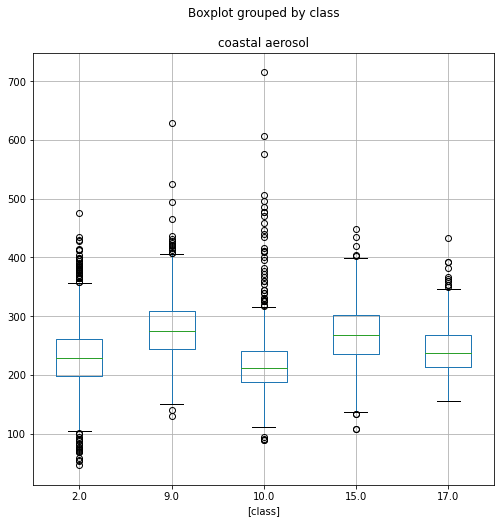

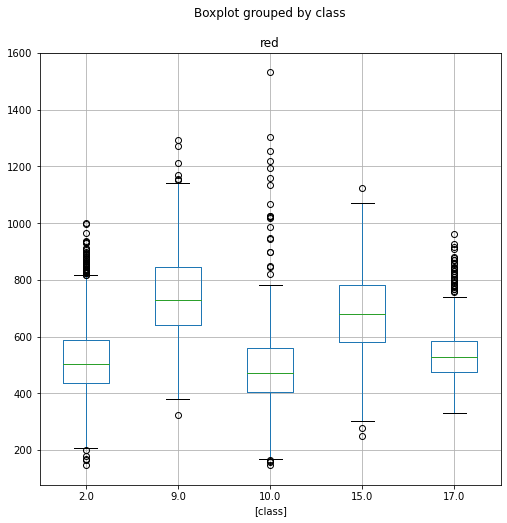

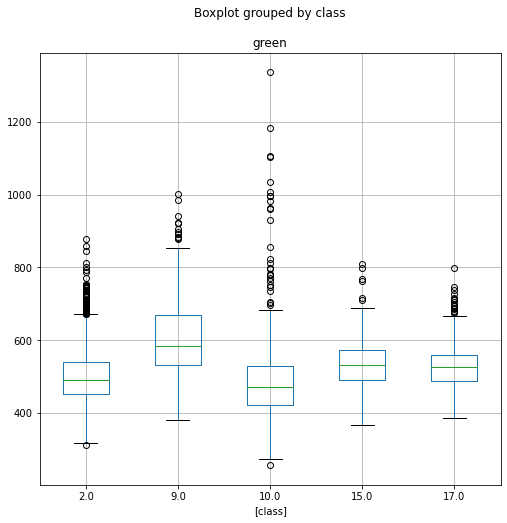

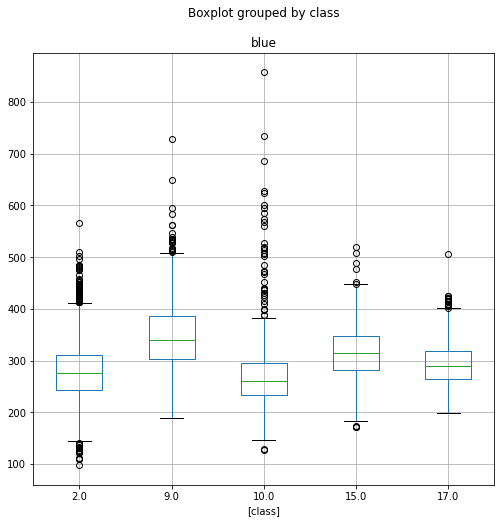

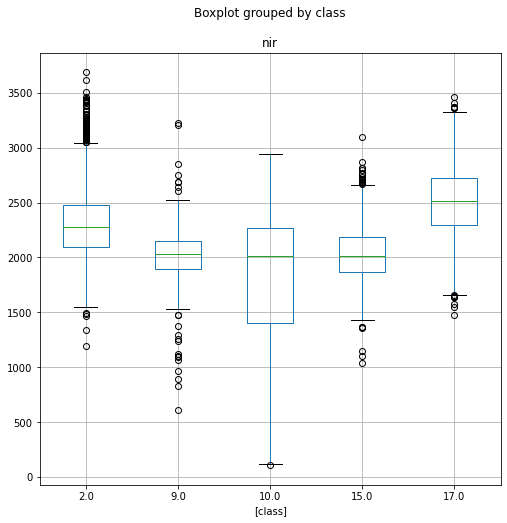

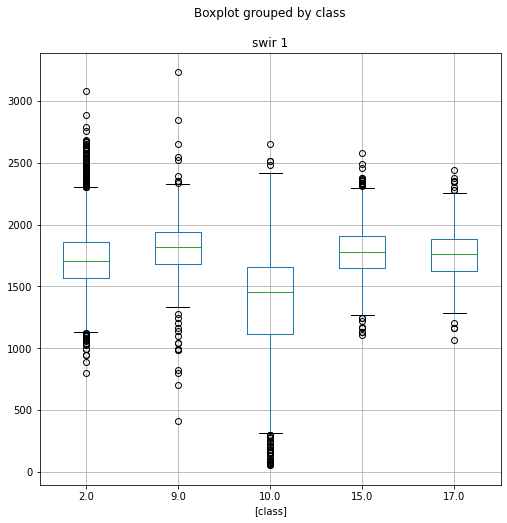

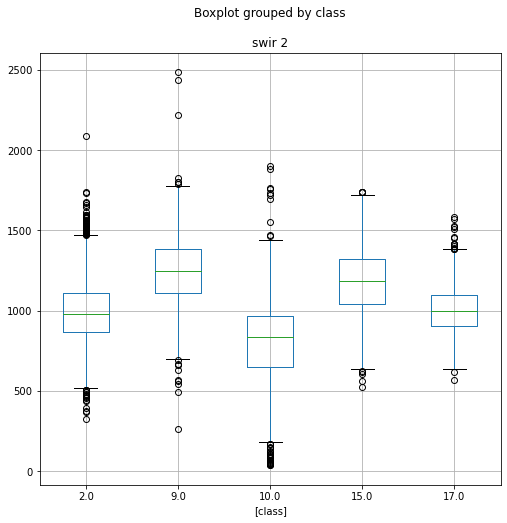

In [192]:
for column in df.columns:
    if column != 'class':
        df.boxplot(column=[column], by=['class'], figsize=(8, 8))

<AxesSubplot:xlabel='red', ylabel='nir'>

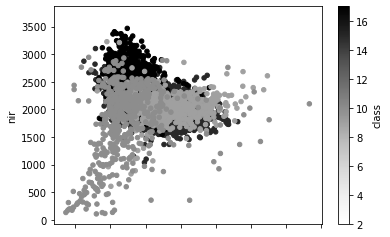

In [202]:
df.plot.scatter(x='red',y='nir', c='class')